<a href="https://colab.research.google.com/github/meleknurb/pytorch_capstone_projects/blob/main/Classifying_Retinal_Images_for_Diabetes_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Retinal Images for Diabetic Retinopathy

In this project, we'll explore how deep learning can assist in detecting diabetic retinopathy (DR) from retinal images. We'll use a real-world dataset called the [Indian Diabetic Retinopathy Image Dataset (IDRiD)](https://idrid.grand-challenge.org/Data/) that contains high-resolution retinal fundus images of patients annotated by medical experts. Notably, the dataset provides the severity of diabetic retinopathy and diabetic macular edema on a grading scale, allowing us to perform multiple types of analysis, such as binary classification ("DR" vs "No DR") or multi-class classification based on disease progression.

The goal of this project is to showcase the potential of image models to assist in the following image task:

## Binary Classification for Diabetic Retinopathy

- Diabetic retinopathy (DR) is a serious complication of diabetes, leading to blindness as a result of high blood sugar levels damaging blood vessels in the retina. Individuals with DR may experience no symptoms in the early stages, but disease progression may lead to vision impairment and blindness. Importantly, studies have shown that early detection of DR through retinal screening can significantly reduce the risk of severe complications. Since manual screening and analysis are time-consuming and expensive, we hope to build an image classification model as an automation tool to support ophthalmologists in large-scale screening efforts to detect DR.

- We'll build two deep learning models with PyTorch:
    - Convolutional Neural Network (CNN)
    - Vision Transformer (ViT)

**Note:** The models and analyses in this project notebook are built and trained on a limited dataset that may not be generalized well to the broader population or clinical settings. Therefore, the models are not intended for real-world medical applications and should not be relied upon for diagnosing, predicting, or managing any health outcomes. Any health-related decisions should always be made with the guidance of a qualified healthcare professional!

## Dataset Summary

The images are 4288×2848 pixels and stored as JPG in the following folders:

- Training: ``'datasets/diabetic_retinopathy_images/images/training_images'``
- Testing: ``'datasets/diabetic_retinopathy_images/images/testing_images'``

The image label information is stored in the following CSV files:

- Training: ``'datasets/diabetic_retinopathy_images/groundtruths/training_labels.csv'``
- Testing: ``'datasets/diabetic_retinopathy_images/groundtruths/testing_labels.csv'``

The column information within each CSV file:

- **Image name:** The file name of the image as a string
- **Retinopathy grade:** The retinopathy grade from 0 (no DR) to 4
- **Risk of macular edema:** The risk of macular edema is graded from 0 to 2
- **Retinopathy:** Binary column for the presence of DR (``0 ==> "No DR" and 1 ==> "DR"``)

Alternatively, if you find that your notebook is running out of memory or if training is too slow, you can use smaller images that we've resized to 224x224 in the following folders:

- Smaller Training: ``'datasets/diabetic_retinopathy_images/images/training_images_small'``
- Smaller Testing: ``'datasets/diabetic_retinopathy_images/images/testing_images_small'``



---



## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
import random
import cv2

from PIL import Image, ImageOps, ImageEnhance
import torch
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from transformers import ViTForImageClassification, ViTImageProcessor
from sklearn.metrics import classification_report, confusion_matrix

torch.manual_seed(42)
warnings.filterwarnings('ignore')
sns.set(style='whitegrid', palette='Paired')
%matplotlib inline



---



## Loading and Inspecting the Datasets

Let's load the CSV files and images.

In [2]:
TRAIN_IMAGES_DIR = "/content/drive/MyDrive/Colab Notebooks/Pytorch Capstone Projects/datasets/diabetic_retinopathy_images/images/training_images"
TEST_IMAGES_DIR = "/content/drive/MyDrive/Colab Notebooks/Pytorch Capstone Projects/datasets/diabetic_retinopathy_images/images/testing_images"

TRAIN_LABELS_DIR = "/content/drive/MyDrive/Colab Notebooks/Pytorch Capstone Projects/datasets/diabetic_retinopathy_images/groundtruths/training_labels.csv"
TEST_LABELS_DIR = "/content/drive/MyDrive/Colab Notebooks/Pytorch Capstone Projects/datasets/diabetic_retinopathy_images/groundtruths/testing_labels.csv"

In [4]:
train_df = pd.read_csv(TRAIN_LABELS_DIR)
test_df = pd.read_csv(TEST_LABELS_DIR)

print(train_df.head())
print(test_df.head())

  Image name  Retinopathy grade  Risk of macular edema  Retinopathy
0  IDRiD_001                  3                      2            1
1  IDRiD_002                  3                      2            1
2  IDRiD_003                  2                      2            1
3  IDRiD_004                  3                      2            1
4  IDRiD_005                  4                      0            1
  Image name  Retinopathy grade  Risk of macular edema   Retinopathy
0  IDRiD_001                  4                       0            1
1  IDRiD_002                  4                       1            1
2  IDRiD_003                  4                       0            1
3  IDRiD_004                  4                       0            1
4  IDRiD_005                  4                       1            1


In [ ]:
print("Training shape:", train_df.shape)
print("Testing shape:", test_df.shape)

Training shape: (413, 4)
Testing shape: (103, 4)


Looks like there are 413 training images and 103 testing images which is approximately an 80/20 split.


In [ ]:
print("Number of null values in train data:", train_df.isnull().sum().sum())
print("Number of null values in test data:", test_df.isnull().sum().sum())

Number of null values in train data: 0
Number of null values in test data: 0


There is no null values in datasets.

**Retinopathy Distribution**

Let's take a look at the distribution of our target column Retinopathy in the training and testing sets.

In [ ]:
print("Training Distribution:", train_df['Retinopathy'].value_counts(), "\n")
print("Testing Distribution:", test_df['Retinopathy'].value_counts())

Training Distribution: Retinopathy
1    279
0    134
Name: count, dtype: int64 

Testing Distribution: Retinopathy
1    69
0    34
Name: count, dtype: int64


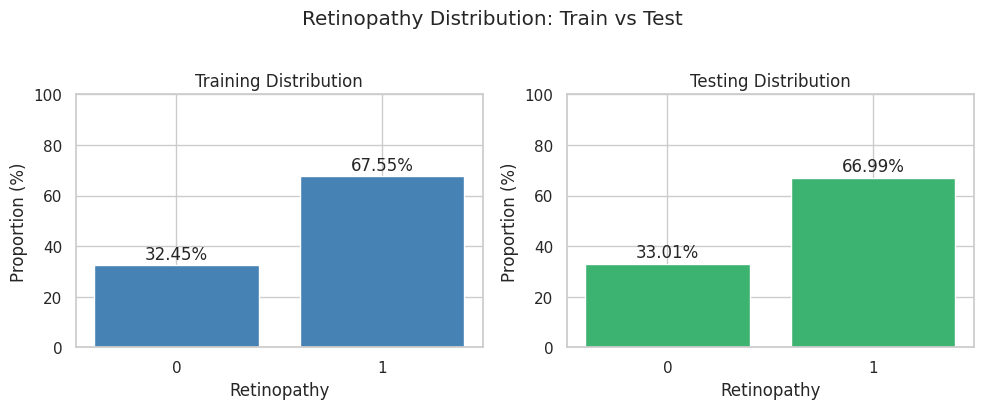

In [ ]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=False) # sharey=False as percentages will be different

# Calculate proportions for training and testing data
train_proportions = train_df['Retinopathy'].value_counts(normalize=True).sort_index() * 100
test_proportions = test_df['Retinopathy'].value_counts(normalize=True).sort_index() * 100

# Plot training distribution
bars_train = axes[0].bar(train_proportions.index.astype(str), train_proportions, color='steelblue')
axes[0].set_title('Training Distribution')
axes[0].set_xlabel('Retinopathy')
axes[0].set_ylabel('Proportion (%)')
axes[0].set_ylim(0, 100)

# Add percentages above the bars for training data
for bar, percentage in zip(bars_train, train_proportions):
    axes[0].text(bar.get_x() + bar.get_width() / 2., bar.get_height() + 1, f'{percentage:.2f}%', ha='center', va='bottom')


# Plot testing distribution
bars_test = axes[1].bar(test_proportions.index.astype(str), test_proportions, color='mediumseagreen')
axes[1].set_title('Testing Distribution')
axes[1].set_xlabel('Retinopathy')
axes[1].set_ylabel('Proportion (%)')
axes[1].set_ylim(0, 100)

# Add percentages above the bars for testing data
for bar, percentage in zip(bars_test, test_proportions):
    axes[1].text(bar.get_x() + bar.get_width() / 2., bar.get_height() + 1, f'{percentage:.2f}%', ha='center', va='bottom')


plt.suptitle('Retinopathy Distribution: Train vs Test', y=1.02)
plt.tight_layout()
plt.show()

It looks like the training and testing set proportions are very similar.

Unfortunately, there is a moderate class imbalance in both sets. The positive class ("DR") has nearly double the representation compared to the negative class ("No DR"). This might cause our image classification models to overfit to the positive class and predict the presence of DR more often. To address this class imbalance, we will apply data augmentation and transformation techniques. Also we will use the ``weight`` parameter in the loss function to give more importance to the minority class during training.

**Retinopathy Grade Distribution**

Let's take a look at the retinopathy grades. In future work, it might be interesting to train a multiclass classification model to predict the severity of DR (not just for the presence of DR, as in our case).

In [ ]:
print("Training Distribution:", train_df['Retinopathy grade'].value_counts(), "\n")
print("Testing Distribution:", test_df['Retinopathy grade'].value_counts())

Training Distribution: Retinopathy grade
2    136
0    134
3     74
4     49
1     20
Name: count, dtype: int64 

Testing Distribution: Retinopathy grade
0    34
2    32
3    19
4    13
1     5
Name: count, dtype: int64


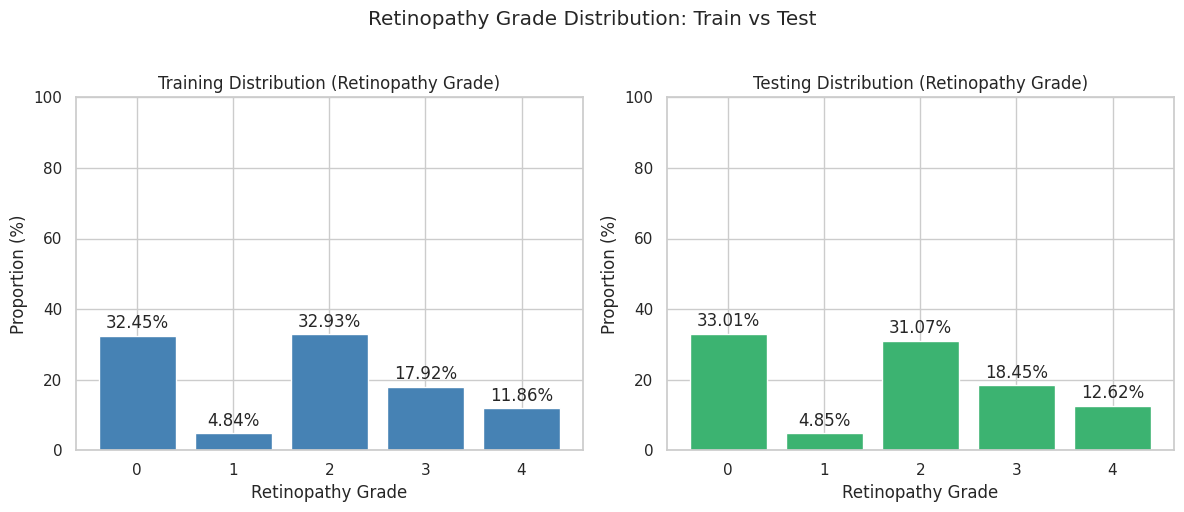

In [ ]:
# Create subplots for Retinopathy grade distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# Calculate proportions for training and testing data for Retinopathy grade
train_grade_proportions = train_df['Retinopathy grade'].value_counts(normalize=True).sort_index() * 100
test_grade_proportions = test_df['Retinopathy grade'].value_counts(normalize=True).sort_index() * 100

# Plot training distribution for Retinopathy grade
bars_train_grade = axes[0].bar(train_grade_proportions.index.astype(str), train_grade_proportions, color='steelblue')
axes[0].set_title('Training Distribution (Retinopathy Grade)')
axes[0].set_xlabel('Retinopathy Grade')
axes[0].set_ylabel('Proportion (%)')
axes[0].set_ylim(0, 100)

# Add percentages above the bars for training data
for bar, percentage in zip(bars_train_grade, train_grade_proportions):
    axes[0].text(bar.get_x() + bar.get_width() / 2., bar.get_height() + 1, f'{percentage:.2f}%', ha='center', va='bottom')

# Plot testing distribution for Retinopathy grade
bars_test_grade = axes[1].bar(test_grade_proportions.index.astype(str), test_grade_proportions, color='mediumseagreen')
axes[1].set_title('Testing Distribution (Retinopathy Grade)')
axes[1].set_xlabel('Retinopathy Grade')
axes[1].set_ylabel('Proportion (%)')
axes[1].set_ylim(0, 100)

# Add percentages above the bars for testing data
for bar, percentage in zip(bars_test_grade, test_grade_proportions):
    axes[1].text(bar.get_x() + bar.get_width() / 2., bar.get_height() + 1, f'{percentage:.2f}%', ha='center', va='bottom')

plt.suptitle('Retinopathy Grade Distribution: Train vs Test', y=1.02)
plt.tight_layout()
plt.show()

As can be seen from the visualization, the distribution of retinopathy grades is similar in both the training and test sets. However, there are significant differences in the amount of data across degrees. In particular, the number of images for Grade 1 retinopathy is significantly lower than for other degrees. This is an issue that should be considered when training a multi-class classification model and may require strategies to cope with class imbalance.

**Sample Images**

Let's examine a randomly selected sample image from the DR and No DR classes.

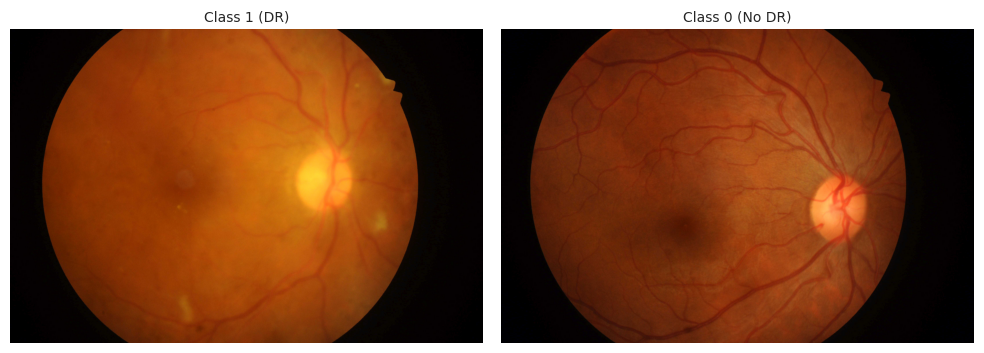

In [ ]:
# Get the two classes (0 and 1) from the 'Retinopathy' column
classes_to_display = train_df['Retinopathy'].unique()

plt.figure(figsize=(10, 5))

# Create a dictionary to map class labels to descriptive names
class_names_map = {0: "No DR", 1: "DR"}

for i, class_label in enumerate(classes_to_display):
    # Filter the dataframe to get images for the current class
    class_df = train_df[train_df['Retinopathy'] == class_label]

    # Get a random image name from the filtered dataframe
    random_image_name = random.choice(class_df['Image name'].tolist()) + ".jpg"

    # Construct the full image path
    image_path = os.path.join(TRAIN_IMAGES_DIR, random_image_name)

    # Read and display the image
    img = Image.open(image_path)

    ax = plt.subplot(1, 2, i + 1)
    plt.imshow(img)
    # Use the descriptive class name in the title
    plt.title(f"Class {class_label} ({class_names_map[class_label]})", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

---

## Pre-Processing

Let's now pre-process the image data.

**Create a Dataset Class**

In [ ]:
class DRDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.labels_df = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        # Extract image name (assuming first column contains image names)
        img_name = self.labels_df.iloc[idx, 0]

        # Construct full image path
        img_path = os.path.join(self.img_dir, f"{img_name}.jpg")
        image = Image.open(img_path).convert('RGB')

        # Get binary label from "Retinopathy" column
        label = self.labels_df.iloc[idx, -1]
        label = torch.tensor(label, dtype=torch.float)

        if self.transform:
            image = self.transform(image)

        return image, label

**Custom Transformation Classes**

While PyTorch provides many useful tools to transform images, we'll also use two custom transformation classes that are known to be particularly useful for analyzing retinal images:

**1. Contrast Limited Adaptive Histogram Equalization (CLAHE)**

- Minimizes noise in retinal images by enhancing the contrast and brightness
- Enhances the green channel, which typically contains the most retinal detail (highlights blood vessels more clearly)
- Research papers:
    - [Improved Image Quality Retinal Fundus with CLAHE and Filter Variation](https://ieeexplore.ieee.org/document/8985198)
    - [CLAHE-CapsNet: Efficient retina optical coherence tomography classification using capsule networks with CLAHE](https://pubmed.ncbi.nlm.nih.gov/38032915/)

**2. Retinal Center Crop**

- Creates a circular mask to isolate the central circular retinal region
- Removes irrelevant corners in the image

In [ ]:
class SimpleCLAHE:
    """A simplified version of CLAHE using PIL"""
    def __init__(self, clip_limit=2.0):
        self.clip_limit = clip_limit

    def __call__(self, img):
        # Enhance contrast and brightness
        enhancer = ImageEnhance.Contrast(img)
        img = enhancer.enhance(1.5)  # Boost contrast

        # Enhance green channel for retinal images
        r, g, b = img.split()
        g_enhanced = ImageEnhance.Contrast(g).enhance(1.8)

        # Recombine with enhanced green channel
        return Image.merge("RGB", (r, g_enhanced, b))

class RetinalCenterCrop:
    """Crop to the center circular region of retinal images"""
    def __call__(self, img):
        # Create a circular mask
        mask = Image.new('L', img.size, 0)
        width, height = img.size
        center = (width//2, height//2)
        radius = min(width, height)//2

        # Circular mask
        from PIL import ImageDraw
        draw = ImageDraw.Draw(mask)
        draw.ellipse((center[0]-radius, center[1]-radius,
                      center[0]+radius, center[1]+radius), fill=255)

        # Apply the mask
        result = img.copy()
        result.putalpha(mask)

        # Create a background of average color
        bg_color = tuple(map(int, np.array(img).mean(axis=(0,1))))
        bg = Image.new('RGB', img.size, bg_color)

        # Paste the masked image onto the background
        bg.paste(result, (0, 0), mask)
        return bg

**Train/Validation/Test Transformation Pipeline**

Let's creating the pre-processing pipeline for the training, validation and testing images. We will split 10% of the training data as the validation dataset.

In [ ]:
train_transforms = transforms.Compose([
    SimpleCLAHE(),
    RetinalCenterCrop(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

])

val_test_transforms = transforms.Compose([
    SimpleCLAHE(),
    RetinalCenterCrop(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

])

**Create the Validation Set**

Let's create a validation set that'll be used to evaluate the image model during training.


In [ ]:
full_dataset = DRDataset(
    img_dir=TRAIN_IMAGES_DIR,
    csv_file=TRAIN_LABELS_DIR,
    transform=None
)

train_size = int(0.9 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_subset, val_subset = random_split(full_dataset, [train_size, val_size])

print(f"Training set size: {len(train_subset)}")
print(f"Validation set size: {len(val_subset)}")

Training set size: 371
Validation set size: 42


**Creating Datasets**

Using the custom DRDataset, we'll load the training, validation and test sets apply the relevant transformation pipelines.


In [ ]:
train_dataset = DRDataset(
    img_dir=TRAIN_IMAGES_DIR,
    csv_file=TRAIN_LABELS_DIR,
    transform=train_transforms
)
train_dataset = Subset(train_dataset, train_subset.indices)

val_dataset = DRDataset(
    img_dir=TRAIN_IMAGES_DIR,
    csv_file=TRAIN_LABELS_DIR,
    transform=val_test_transforms
)
val_dataset = Subset(val_dataset, val_subset.indices)

test_dataset = DRDataset(
    img_dir=TEST_IMAGES_DIR,
    csv_file=TEST_LABELS_DIR,
    transform=val_test_transforms
)

print("Training size:", len(train_dataset))
print("Validation size:", len(val_dataset))
print("Testing size:", len(test_dataset))

Training size: 371
Validation size: 42
Testing size: 103


**Create the Training/Validation/Testing Batches**

In [ ]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False
)

print(f"Number of training batches: {len(train_dataloader)}")
print(f"Number of validation batches: {len(val_dataloader)}")
print(f"Number of test batches: {len(test_dataloader)}")

Number of training batches: 12
Number of validation batches: 2
Number of test batches: 7


**Visualize Training Images: Before and After Transformation**

Let's visualize a few images to get a sense of how the transformation pipeline is augmenting the training images.


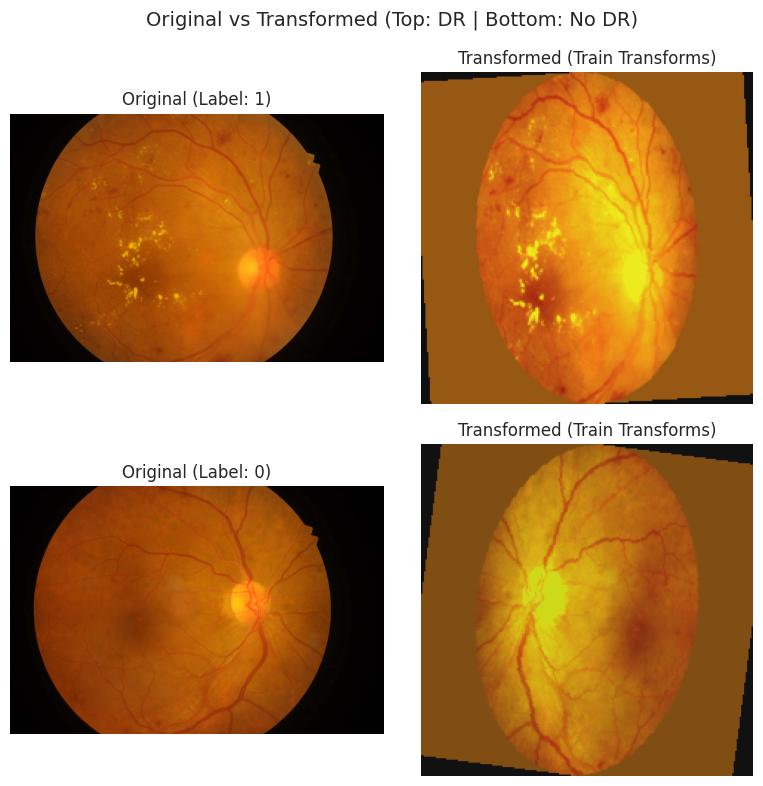

In [ ]:
raw_dataset = DRDataset(
    img_dir=TRAIN_IMAGES_DIR,
    csv_file=TRAIN_LABELS_DIR,
    transform=None
)

# idx 0 = DR, idx 117 = No DR
indices = [0, 117]

def denormalize(tensor_img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    for t, m, s in zip(tensor_img, mean, std):
        t.mul_(s).add_(m)
    return tensor_img

# Convert tensor to PIL
to_pil = transforms.ToPILImage()

# Plot setup
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle('Original vs Transformed (Top: DR | Bottom: No DR)', fontsize=14)

# Create a dataset with the training transforms applied
visualize_dataset = DRDataset(
    img_dir=TRAIN_IMAGES_DIR,
    csv_file=TRAIN_LABELS_DIR,
    transform=train_transforms # Use the train_transforms for visualization
)

for row_idx, idx in enumerate(indices):
    original_img, label = raw_dataset[idx] # Get original image from raw_dataset

    # Get transformed image from visualize_dataset
    # The transform is applied in __getitem__ of visualize_dataset
    transformed_img, _ = visualize_dataset[idx]

    # Denormalize the transformed tensor image
    transformed_img = denormalize(transformed_img.clone()).clamp(0, 1)

    # Left: Original
    axes[row_idx, 0].imshow(original_img)
    axes[row_idx, 0].set_title(f"Original (Label: {int(label.item())})")
    axes[row_idx, 0].axis("off")

    # Right: Transformed
    axes[row_idx, 1].imshow(to_pil(transformed_img)) # Convert tensor back to PIL for displaying
    axes[row_idx, 1].set_title("Transformed (Train Transforms)")
    axes[row_idx, 1].axis("off")

plt.tight_layout()
plt.show()

---

## Image Classification Models

 ### 1. Convolutional Neural Network (CNN)

**Build the CNN Architecture**

In [ ]:
class DRCNN(nn.Module):
    def __init__(self):
      super(DRCNN, self).__init__()
      # Convolutional layers
      self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
      self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
      self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

      # FC layers
      self.fc1 = nn.Linear(64 * 28 * 28, 128)
      self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2)
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(x,2)

      # Flatten
      x = x.view(x.size(0), -1)

      # Fully connected layers
      x = F.relu(self.fc1(x))
      x = torch.sigmoid(self.fc2(x)).squeeze(1)

      return x

cnn_model = DRCNN()

**Move device to GPU**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn_model.to(device)

print(device)

cuda


**Initialize the Loss Function and Optimizer**

Since there is moderate class imbalance, we'll use the weight parameter in the BCELoss loss function to manually rescale the weights given to each image's loss based on its class.

- If the model makes an error on the minority class, the loss is ~2x more costly than making errors on the majority class.


In [ ]:
# Weight for minority class
weight = torch.tensor([279/134]).to(device)
criterion = nn.BCELoss(weight=weight)

optimizer = optim.Adam(cnn_model.parameters(),lr=0.001)

print('Loss Function:',criterion)
print('Optimizer:',optimizer)

Loss Function: BCELoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


**Training Loop**

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10
for epoch in range(num_epochs):
    total_train_loss = 0
    total_val_loss = 0
    correct_train_predictions = 0
    total_train_samples = 0
    correct_val_predictions = 0
    total_val_samples = 0


    # Training
    cnn_model.train()
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

        predictions = (outputs > 0.5).float()

        correct_train_predictions += (predictions == labels).sum().item()
        total_train_samples += labels.size(0)


    # Validation
    cnn_model.eval()
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = cnn_model(images)
            val_loss = criterion(outputs, labels)
            total_val_loss += val_loss.item()

            predictions = (outputs > 0.5).float()

            correct_val_predictions += (predictions == labels).sum().item()
            total_val_samples += labels.size(0)


    # Calculate average losses and accuracies
    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_val_loss = total_val_loss / len(val_dataloader)
    train_accuracy = correct_train_predictions / total_train_samples
    val_accuracy = correct_val_predictions / total_val_samples

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Print training and validation losses and accuracies
    print(f"epoch [{epoch+1}/{num_epochs}] - accuracy: {train_accuracy:.4f} - loss: {avg_train_loss:.4f} - val_accuracy: {val_accuracy:.4f} - val_loss: {avg_val_loss:.4f}")

epoch [1/10] - accuracy: 0.5418 - loss: 1.5879 - val_accuracy: 0.6667 - val_loss: 1.4276
epoch [2/10] - accuracy: 0.6765 - loss: 1.4203 - val_accuracy: 0.6667 - val_loss: 1.3861
epoch [3/10] - accuracy: 0.6765 - loss: 1.3288 - val_accuracy: 0.6667 - val_loss: 1.2011
epoch [4/10] - accuracy: 0.6765 - loss: 1.2761 - val_accuracy: 0.6667 - val_loss: 1.1832
epoch [5/10] - accuracy: 0.6900 - loss: 1.2210 - val_accuracy: 0.6905 - val_loss: 1.2179
epoch [6/10] - accuracy: 0.7305 - loss: 1.1776 - val_accuracy: 0.6429 - val_loss: 1.1308
epoch [7/10] - accuracy: 0.7251 - loss: 1.1348 - val_accuracy: 0.7143 - val_loss: 1.0750
epoch [8/10] - accuracy: 0.6954 - loss: 1.1777 - val_accuracy: 0.6667 - val_loss: 1.1228
epoch [9/10] - accuracy: 0.7520 - loss: 1.1395 - val_accuracy: 0.6190 - val_loss: 1.1203
epoch [10/10] - accuracy: 0.7601 - loss: 1.0980 - val_accuracy: 0.7143 - val_loss: 1.1091


**Visualize the Accuracies and Losses**


In [ ]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

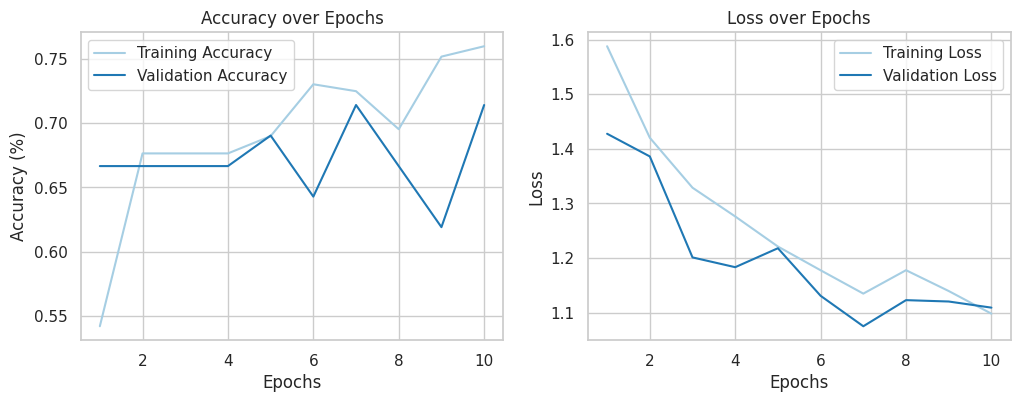

In [ ]:
epochs = range(1, len(train_losses) + 1)
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

An examination of the model's training performance reveals a generally steady decline in training loss, while training accuracy increases accordingly. This demonstrates the model's ability to successfully learn patterns from the training set. Training accuracy reached 76.01% at epoch 10, confirming its good performance on the training data.

However, performance on the validation set requires more careful interpretation. While validation loss decreased in some epochs, there were significant increases in epochs 5 and 8. These increases may be an early sign that the model is overfitting the training data. While a slight decrease in validation loss in epoch 10 is positive, these fluctuations in the overall trend suggest that the model is not yet fully generalizing or that the training process may not be optimal at this point.

Validation accuracy was also lower and fluctuated compared to training accuracy. The decreases in epochs 6 and 9 suggest that the model's performance across different examples in the validation set may have been inconsistent or that the effect of overfitting became more pronounced in these epochs. We can say that overfitting began, especially after the 7th epoch.

**Potential Issues and Observations:**

- **Signs of Overfitting:** If the validation loss increases at certain points while the training loss continues to decrease, this may indicate that the model is memorizing the training data and is having difficulty generalizing to data it has not seen before.

- **The Impact of a Small Validation Set:** A validation set of only 42 samples can make fluctuations in accuracy and loss metrics more pronounced and give a misleading impression of the model's true generalization ability.

- **Class Imbalance:** Initially detected class imbalance can cause the model to focus more on the majority class (DR) and negatively impact performance on the minority class (No DR). While the weighted loss function attempts to address this, the results may show lower accuracy or F1-scores for the minority class.

At this point, evaluation on the test set is critical to better understand the true performance of the model.

**Testing Set Evaluation**

In [ ]:
test_pred_probs = []
test_pred_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)

        # Get model outputs (already has sigmoid activation)
        outputs = cnn_model(images)

        # Store probabilities
        test_pred_probs.extend(outputs.cpu().numpy())

        # Get predicted labels (threshold at 0.5)
        pred_labels = torch.round(outputs)
        test_pred_labels.extend(pred_labels.cpu().numpy())

# Convert to numpy arrays for easier handling
test_pred_probs = np.array(test_pred_probs)
test_pred_labels = np.array(test_pred_labels)

# Show output
print("First image predicted probability:", test_pred_probs[0])
print("First image predicted label:", test_pred_labels[0])
print("First image actual label:", labels[0].item())

First image predicted probability: 0.41333446
First image predicted label: 0.0
First image actual label: 0.0


In [ ]:
test_true_labels = []
for _, labels in test_dataloader:
    test_true_labels.extend(labels.numpy())

dr_classes = ['No DR', 'DR']
report = classification_report(test_true_labels, test_pred_labels,target_names=dr_classes)

print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       No DR       0.50      0.29      0.37        34
          DR       0.71      0.86      0.78        69

    accuracy                           0.67       103
   macro avg       0.61      0.57      0.57       103
weighted avg       0.64      0.67      0.64       103



##### **Key Insights (CNN)**

The baseline CNN for detecting diabetic retinopathy achieved an overall accuracy of 67%. This means that the model correctly predicted 67% of all images in the testing set, which can be considered modest, but there is certainly room for improvement. Let's take a look at the performance for each class.

**Class 0 Performance (No DR)**

Within patients who do not have diabetic retinopathy:

- A precision of 0.50 means that when the CNN predicted a patient did not have DR, it was only correct 50% of the time
- A recall of 0.29 means that the CNN correctly identified only 29% of patients without DR
- An F1-score of 0.37 suggests a poor balance between the precision and recall score for class 0

**Class 1 Performance (DR)**

Within patients who do have diabetic retinopathy:

- A precision of 0.71 means that when the CNN predicted a patient with DR, it was correct 71% of the time
- A recall of 0.86 means that the CNN correctly identified 86% of patients with DR
- An F1-score of 0.78 suggests a decent balance between recall and precision for class 1.

The higher scores for patients with DR (class 1) are most likely due to model bias, as a result of the class imbalance in the training data, which consists mostly of patients with DR. This is evidence that the model is biased towards predicting patients with DR and that it hasn't fully learned meaningful and generalizable patterns. We may need to rethink our class imbalance strategy in order to improve CNN's performance.

From a clinical perspective, higher performance metrics would be needed for both classes. The overall accuracy of 67% is too low to be relied upon for clinical use. Notably, the model is severely struggling to classify healthy individuals without DR. The model is only able to identify 29% of healthy patients, which is incredibly dangerous and misleading, as it is incorrectly classifying the other 71% of healthy patients as having DR. While the class 1 performance looks decent, there is clear evidence that the model is biased towards classifying patients with DR.

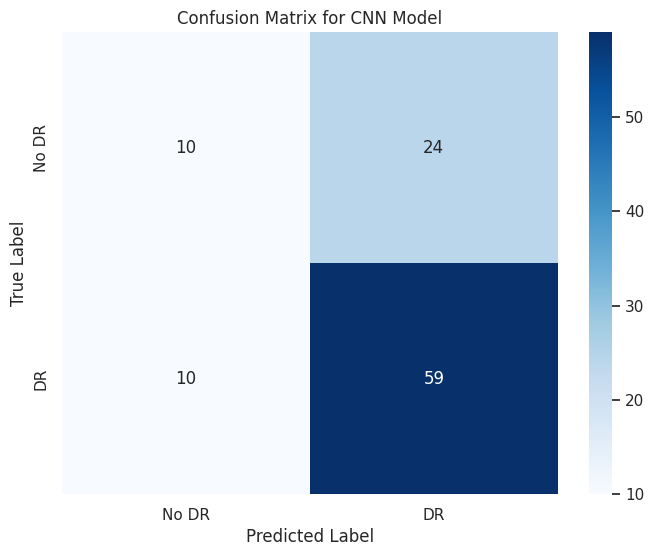

In [ ]:
# Generate and plot the confusion matrix
matrix = confusion_matrix(test_true_labels, test_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dr_classes, yticklabels=dr_classes)
plt.title('Confusion Matrix for CNN Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

When we look at the confusion matrix;

- **True Negatives (TN):** The model correctly predicted 10 of the 34 cases that were actually "No DR" as "No DR."
- **False Positives (FP):** The model incorrectly predicted 24 of the 34 cases that were actually "No DR" as "DR."
- **False Negatives (FN):** The model incorrectly predicted 10 of the 69 cases that were actually "DR" as "No DR."
- **True Positives (TP):** The model correctly predicted 59 of the 69 cases that were actually "DR" as "DR."

The confusion matrix visually supported our observations in the classification report.

---

### Vision Transformer (ViT)

Let's now train a more advanced image model: the Vision Transformer!

We'll use a standard pre-trained ViT transformer from Hugging Face:

- [https://huggingface.co/google/vit-base-patch16-224](https://huggingface.co/google/vit-base-patch16-224)

**Load a Pre-Trained ViT**



In [ ]:
np.random.seed(42)
random.seed(42)

# For CUDA
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
model_name = "google/vit-base-patch16-224"
vit_model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=2,
    ignore_mismatched_sizes=True
)

processor = ViTImageProcessor.from_pretrained(model_name)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

**Move to GPU**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model.to(device)

print(device)

cuda


**ViT Training/Validation/Testing Transformation Pipeline**

In [ ]:
vit_train_transforms = transforms.Compose([
    SimpleCLAHE(),
    RetinalCenterCrop(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean,std=processor.image_std)

])

vit_val_test_transforms = transforms.Compose([
    SimpleCLAHE(),
    RetinalCenterCrop(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean,std=processor.image_std)

])

**Create the Validation Set**




Given the small dataset and the fluctuations in CNN's validation metrics (with a 10% split), we'll increase the ViT validation set to 20%. This provides a more robust evaluation and better sense of generalization, reducing small-sample variability impact.

In [ ]:
full_dataset = DRDataset(
    img_dir=TRAIN_IMAGES_DIR,
    csv_file=TRAIN_LABELS_DIR,
    transform=None
)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_subset, val_subset = random_split(full_dataset, [train_size, val_size])

print(f"Training set size: {len(train_subset)}")
print(f"Validation set size: {len(val_subset)}")

Training set size: 330
Validation set size: 83


**Creating Datasets**

In [ ]:
train_dataset = DRDataset(
    img_dir=TRAIN_IMAGES_DIR,
    csv_file=TRAIN_LABELS_DIR,
    transform=vit_train_transforms
)
train_dataset = Subset(train_dataset, train_subset.indices)

val_dataset = DRDataset(
    img_dir=TRAIN_IMAGES_DIR,
    csv_file=TRAIN_LABELS_DIR,
    transform=vit_val_test_transforms
)
val_dataset = Subset(val_dataset, val_subset.indices)

test_dataset = DRDataset(
    img_dir=TEST_IMAGES_DIR,
    csv_file=TEST_LABELS_DIR,
    transform=vit_val_test_transforms
)

print("Training size:", len(train_dataset))
print("Validation size:", len(val_dataset))
print("Testing size:", len(test_dataset))

Training size: 330
Validation size: 83
Testing size: 103


**Create the Training/Validation/Testing Batches**

In [ ]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False
)

print(f"Number of training batches: {len(train_dataloader)}")
print(f"Number of validation batches: {len(val_dataloader)}")
print(f"Number of test batches: {len(test_dataloader)}")

Number of training batches: 11
Number of validation batches: 3
Number of test batches: 7


**Freeze and Unfreeze Layers**

- Freeze all layers
- Unfreeze the last two transformer layers
- Unfreeze the classification head

In [ ]:
# Freeze all layers
for param in vit_model.parameters():
    param.requires_grad = False

# Unfreeze the final transformer blocks and classifier
for param in vit_model.vit.encoder.layer[-1:].parameters():
    param.requires_grad = True

for param in vit_model.classifier.parameters():
    param.requires_grad = True

**Initialize Loss Function and Optimizer**

- We'll use the Adam variant ``AdamW`` with decay and apply different learning rates to each layer to be fine-tuned.

- We'll also use the ``weight`` parameter in the ``CrossEntropyLoss`` loss function to account for class imbalance.
    - Unlike the CNN (using BCELoss for sigmoid output), the ViT model outputs raw logits. CrossEntropyLoss is used here as it's suitable for models outputting logits (it includes softmax and log-likelihood loss), even for binary tasks like ours (num_labels=2 handles this).

In [ ]:
# AdamW optimizer with weight decay
optimizer = optim.AdamW([
    {'params': vit_model.classifier.parameters(), 'lr': 1e-3, 'weight_decay':0.01},
    {'params': vit_model.vit.encoder.layer[-1].parameters(), 'lr': 1e-4, 'weight_decay':0.01}])

# Calculate class weights based on inverse frequency
class_counts = torch.tensor([134, 279], dtype=torch.float)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()
class_weights = class_weights * 2
class_weights = class_weights.to(device)

# Use weighted CrossEntropyLoss loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

**Training Loop**

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10
for epoch in range(num_epochs):
    total_train_loss = 0
    total_val_loss = 0
    train_correct = 0
    train_total = 0
    val_correct = 0
    val_total = 0

    # Training
    vit_model.train()
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device).long()
        optimizer.zero_grad()
        outputs = vit_model(pixel_values=images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        preds = outputs.argmax(dim=1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)

    vit_model.eval()
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device).long()
            outputs = vit_model(pixel_values=images).logits
            val_loss = criterion(outputs, labels)

            total_val_loss += val_loss.item()
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    # Calculate average losses and accuracies
    avg_train_loss = total_train_loss / len(train_dataloader)
    avg_val_loss = total_val_loss / len(val_dataloader)
    train_accuracy = train_correct / train_total
    val_accuracy = val_correct / val_total

    # Save the average training and validation metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Print training and validation metrics
    print(f"epoch [{epoch+1}/{num_epochs}] - accuracy: {train_accuracy:.4f} - loss: {avg_train_loss:.4f} - val_accuracy: {val_accuracy:.4f} - val_loss: {avg_val_loss:.4f}")

epoch [1/10] - accuracy: 0.6273 - loss: 0.6124 - val_accuracy: 0.7470 - val_loss: 0.4958
epoch [2/10] - accuracy: 0.7758 - loss: 0.4463 - val_accuracy: 0.7229 - val_loss: 0.4311
epoch [3/10] - accuracy: 0.8212 - loss: 0.3470 - val_accuracy: 0.7952 - val_loss: 0.3562
epoch [4/10] - accuracy: 0.8515 - loss: 0.3178 - val_accuracy: 0.8072 - val_loss: 0.3421
epoch [5/10] - accuracy: 0.8576 - loss: 0.2927 - val_accuracy: 0.8072 - val_loss: 0.3799
epoch [6/10] - accuracy: 0.8697 - loss: 0.2590 - val_accuracy: 0.7831 - val_loss: 0.4110
epoch [7/10] - accuracy: 0.8848 - loss: 0.2554 - val_accuracy: 0.7952 - val_loss: 0.3670
epoch [8/10] - accuracy: 0.8970 - loss: 0.2635 - val_accuracy: 0.8072 - val_loss: 0.3285
epoch [9/10] - accuracy: 0.8939 - loss: 0.2372 - val_accuracy: 0.8313 - val_loss: 0.3267
epoch [10/10] - accuracy: 0.9061 - loss: 0.2373 - val_accuracy: 0.8554 - val_loss: 0.3012


**Visualize the Accuracies and Losses**

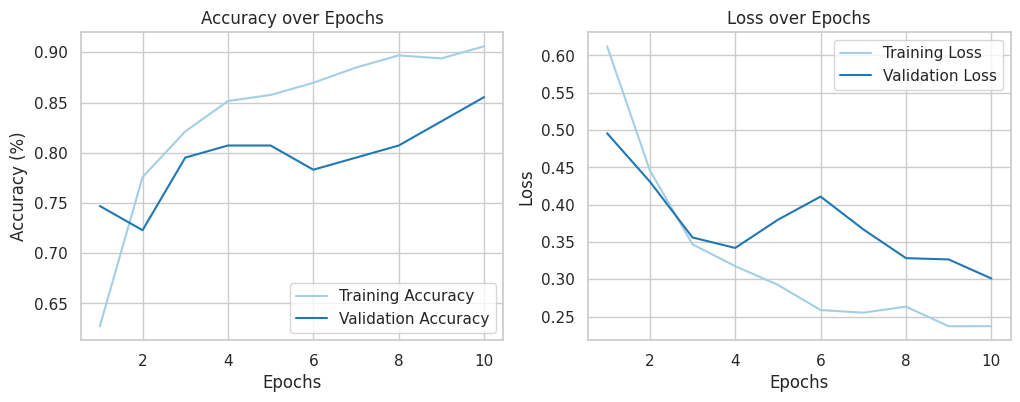

In [ ]:
epochs = range(1, len(train_losses) + 1)

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

When we examine the 10-epoch training process of the ViT model, we observe a significant improvement in training metrics.

- **Training Loss:** It showed a steady and continuous decrease across epochs. This indicates that the model successfully learned the patterns in the training data and reduced prediction errors.
- **Validation Loss:** While it did not exhibit as steady a decrease as the training loss, it generally showed a decreasing trend, with fluctuations and slight increases in some epochs.

These fluctuations in validation loss may indicate a slight tendency toward overfitting, even if the model doesn't perfectly fit the training data. However, the overall increase in validation accuracy and the decline in validation loss in the final epochs suggest that this overfitting is not significant and that the model largely maintains its generalization ability.

Furthermore, the relatively small size of the dataset (especially the validation set) can make these fluctuations more pronounced, making it difficult to make definitive statements about the model's generalization ability. In small datasets, a few samples in the validation set can influence the model's prediction, leading to larger fluctuations in the metrics.

**Comparison with CNN:**

Considering the more pronounced fluctuations in the CNN model's validation metrics and signs of overfitting, the ViT model underwent a much more stable and successful training process. The overall improvement in both training and validation performance confirms that ViT is significantly superior to the CNN for this task.

In summary, the ViT model learned very well on the training set and maintained its generalization ability, demonstrating strong performance on the validation set. While the small fluctuations in the validation loss are a sign of slight overfitting and an effect of the small dataset, the model's overall performance and significant superiority over the CNN are noteworthy.

**Testing Set Evaluation**

In [ ]:
vit_model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device).long()

        outputs = vit_model(pixel_values=images).logits
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        correct += (preds == labels).sum().item()
        total += labels.size(0)

# Show output
print("First image predicted class:", all_preds[0])
print("First image actual label:", all_labels[0])

First image predicted class: 1
First image actual label: 1


In [ ]:
dr_classes = ["No DR", "DR"]
report = classification_report(all_labels,all_preds,target_names=dr_classes)

print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       No DR       0.69      0.79      0.74        34
          DR       0.89      0.83      0.86        69

    accuracy                           0.82       103
   macro avg       0.79      0.81      0.80       103
weighted avg       0.83      0.82      0.82       103



##### **Key Insights (ViT)**

The fine-tuned vision transformer for detecting diabetic retinopathy achieved an overall accuracy of 82%. This means that the model correctly predicted 82% of all images in the testing set, which can be considered decent and a significant improvement over the CNN, which achieved an overall accuracy of only 67%.

Let's take a look at the performance for each class.

**Class 0 Performance (No DR)**

Within patients who do not have diabetic retinopathy:

- A precision of 0.69 means that when the ViT predicted a patient did not have DR, it was correct 69% of the time, which is much better than the CNN, which had a precision of 0.50.

- A recall of 0.79 means that the ViT correctly identified  79% of patients without DR,  this is much better than the CNN, with a recall of 0.29.

- An F1-score of 0.74 suggests a good balance between the precision and recall score for class 0, and is significantly better than the CNN F1-score of 0.37.

**Class 1 Performance (DR)**

Within patients who do have diabetic retinopathy:

- A precision of 0.89 means that when the CNN predicted a patient with DR, it was correct 89% of the time, which is much better than the CNN's precision of 0.71.

- A recall of 0.83 means that the CNN correctly identified 83% of patients with DR, which is slightly worse than  CNN recall of 0.86.

- An F1-score of 0.86 suggests a great balance between recall and precision for class 1, and is improved over the CNN F1-score of 0.78.

**Overall**

Overall, the ViT significantly outperformed the CNN across all metrics except recall.  Unlike CNN, whose bias to overpredict the majority class (patients DR) results in an inflated recall score, the ViT appears more balanced and performs well across both classes. Furthermore, the better F1-scores for the ViT in both classes suggest that the ViT has better learned generalizations than the CNN to classify diabetes retinopathy within the images.

From a clinical perspective, the ViT is significantly better than the CNN. The ViT's balanced performance makes it a more reliable model regarding safety and decision-making.

- False negatives (missed DR) can delay critical care to patients in need
- False positives (misdiagnosing No DR as DR) can cause unnecessary anxiety, referrals, and resource strain among patients

A clinically useful model must balance high sensitivity (recall) and high specificity (precision) across both classes, which the ViT offers more than the CNN.

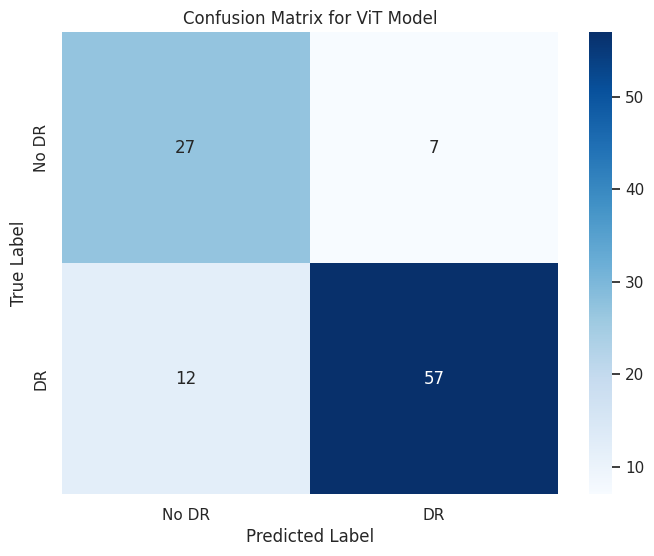

In [ ]:
matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dr_classes, yticklabels=dr_classes)
plt.title('Confusion Matrix for ViT Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

The confusion matrix provides a detailed breakdown of the ViT model's predictions:

- True Negatives (TN): It correctly predicted 27 of the 34 cases that were actually "No DR" as "No DR" (CNN had 10).
- False Positives (FP): It incorrectly predicted only 7 of the 34 cases that were actually "No DR" as "DR" (CNN had 24). This indicates a significant reduction in false alarms.
- False Negatives (FN): It incorrectly predicted 12 of the 69 cases that were actually "DR" as "No DR" (CNN had 10).
- True Positives (TP): It correctly predicted 57 of the 69 cases that were actually "DR" as "DR" (CNN had 59).

**Overall**

Overall, the confusion matrix results for ViT indicate that the model makes significantly more stable and reliable predictions than CNN. In particular, the dramatic decrease in the number of False Positives (from 24 to 7) highlights the model's reduced tendency to incorrectly classify disease-free individuals as having disease, which could significantly reduce false alarms and unnecessary worry in clinical applications. Although the number of False Negatives (12) is slightly higher than that of CNN (10), the model's overall accuracy, and particularly its performance in the "No DR" class, demonstrates that ViT exhibits better generalization ability in the diabetic retinopathy detection task. This matrix clearly demonstrates that ViT can more effectively distinguish between both the "DR" and "No DR" classes, supporting the high F1 scores in the classification report.

---

## Conclusion

This project successfully explored the application of deep learning models for the binary classification of diabetic retinopathy (DR) from retinal fundus images using the IDRiD dataset. We developed and evaluated two distinct models: a baseline Convolutional Neural Network (CNN) and a fine-tuned Vision Transformer (ViT) utilizing a pre-trained model from Hugging Face.

Our initial analysis of the dataset revealed a moderate class imbalance, with the positive class ("DR") having significantly more samples than the negative class ("No DR"). To address this, we implemented data augmentation techniques and incorporated class weighting into the loss functions during training for both models.

The CNN model served as a baseline and, while showing some learning on the training data, exhibited signs of overfitting and struggled particularly with classifying the minority class ("No DR"). The classification report and confusion matrix highlighted its bias towards the majority class, resulting in low precision and recall for "No DR" cases.

The Vision Transformer (ViT) model, benefiting from transfer learning and a slightly larger validation split, demonstrated significantly superior performance. The training process for the ViT was more stable, with training loss consistently decreasing and validation loss showing a general downward trend despite some minor fluctuations, which could be attributed to the small dataset size. On the test set, the ViT achieved a higher overall accuracy (82% vs 67% for CNN) and, critically, showed much better-balanced performance across both classes. Its higher precision and recall for the "No DR" class, as evidenced by the classification report and the significantly reduced number of false positives in the confusion matrix, indicate a better generalization ability and reduced bias compared to the CNN.

The use of custom transformation classes like SimpleCLAHE and RetinalCenterCrop, tailored for retinal images, likely contributed to enhancing the relevant features for both models. The fine-tuning approach on the pre-trained ViT model proved highly effective, leveraging the power of a model pre-trained on a massive dataset to achieve better results on this specialized task.

While the ViT model represents a significant improvement and shows promising results for aiding in DR detection, it's important to acknowledge the limitations of this study, primarily the relatively small size of the IDRiD dataset. The results obtained here, while encouraging, may not fully generalize to larger, more diverse real-world clinical datasets.

**Future Work**

To further advance this work, future research could explore:

*   **Exploring different model architectures:** Investigating other state-of-the-art CNNs or more advanced transformer architectures.
*   **Utilizing specialized pre-trained models:** Exploring models pre-trained on medical imaging datasets.
*   **Advanced dataset balancing techniques:** Experimenting with techniques like SMOTE, or generative models (GANs) to synthesize data for minority classes.
*   **Collecting more data:** Accessing larger and more diverse datasets is crucial for building robust and generalizable models for clinical use.
*   **More rigorous testing and validation strategies:** Implementing k-fold cross-validation or external validation on independent datasets.
*   **Multi-class classification:** Expanding the task to predict the specific retinopathy grade (0-4) to provide more detailed diagnostic information.
*   **Model Interpretability:** Applying techniques to understand which parts of the image the model focuses on for its predictions (e.g., using Grad-CAM) to build trust and provide insights to clinicians.

In conclusion, this project successfully demonstrated the potential of fine-tuned Vision Transformers for diabetic retinopathy classification, significantly outperforming a baseline CNN. The findings highlight the importance of appropriate pre-processing, transfer learning, and strategies to address class imbalance in medical image analysis tasks.

---